In [1]:
import re
import gc
gc.enable()

import numpy as np
import pandas as pd
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from jupyterthemes import jtplot
jtplot.style(ticks=True, grid=True, figsize=(20, 10))
%matplotlib inline

Things to do:

- Can use release date to make generalizations.  E.g. if it's relaesed around valentines day and is a romance movie it may be more popular than if it was released during the summer.  Could make anew column based on release window
- Need to extract values from dictionaries for 'belongs_to_collection', 'genres', 'spoken_languages', 'keywords', 'cast', etc.
- Need to take into account if a title is a sequel
- Can make a column to determine how successful a movie was (i.e. revenue - budget)
- Can make a column with number of words in title
- For movies with $0 budget, can use linear regression to predict value (could use things like cast/crew size, release year, etc. as predictors)

In [2]:
# Function to reduce memory usage.  From: https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

## EDA
It's likely features like budget, popularity, and release date will correlate strongly with revenue.  By contrast, features like poster path might not be helpful without extensive analysis.

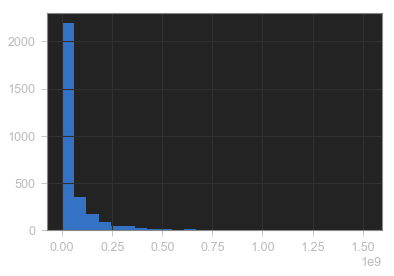

In [5]:
# Revenues are not uniformally distributed
train['revenue'].hist(bins=25)

In [6]:
# When comparing the listed revenues with their actual values found online, 
# it's clear the values given here are not accurate.
train.sort_values('revenue').head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
347,348,NaN,12,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",NaN,tt0118172,en,The Wind in the Willows,"Jailed for his reckless driving, rambunctious ...",1.410322,...,10/16/96,84.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Go wild in the country!,The Wind in the Willows,NaN,"[{'cast_id': 2, 'character': 'Toad', 'credit_i...","[{'credit_id': '59ce7655c3a3686aca01a522', 'de...",1
1754,1755,NaN,2,"[{'id': 53, 'name': 'Thriller'}, {'id': 10769,...",NaN,tt0110604,en,Mute Witness,"Billy is mute, but it hasn't kept her from bec...",2.466066,...,9/28/95,95.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}, {'iso...",Released,She Can't Speak. She Can't Scream. She Can't B...,Mute Witness,"[{'id': 3713, 'name': 'chase'}, {'id': 6149, '...","[{'cast_id': 22, 'character': 'Billy Hughes', ...","[{'credit_id': '52fe4775c3a36847f8136af1', 'de...",1
1917,1918,NaN,592,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,tt0016104,en,The Merry Widow,Prince Danilo falls in love with dancer Sally ...,0.286719,...,8/26/25,137.0,NaN,Released,NaN,The Merry Widow,"[{'id': 1691, 'name': 'dance'}, {'id': 10181, ...","[{'cast_id': 2, 'character': ""Sally O'Hara"", '...","[{'credit_id': '57351170c3a36802410000d5', 'de...",1
1874,1875,NaN,0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",http://www.vt4.be/vermist,tt1133617,en,Vermist,Five members of the Missing Persons Task Force...,0.229233,...,1/1/07,0.0,"[{'iso_639_1': 'nl', 'name': 'Nederlands'}]",Released,NaN,Missing,NaN,"[{'cast_id': 2, 'character': 'Murat Hoxha', 'c...","[{'credit_id': '52fe4838c3a36847f815cef1', 'de...",1
695,696,NaN,1,"[{'id': 10749, 'name': 'Romance'}, {'id': 53, ...",NaN,tt0374271,hi,Tere Naam,"Lower Caste Radhey Mohan is a no good slacker,...",1.280455,...,8/15/03,132.0,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Released,Unfortunately a true love story,Tere Naam,NaN,"[{'cast_id': 3, 'character': 'Radhe Mohan', 'c...","[{'credit_id': '52fe491ec3a36847f8189cfb', 'de...",2


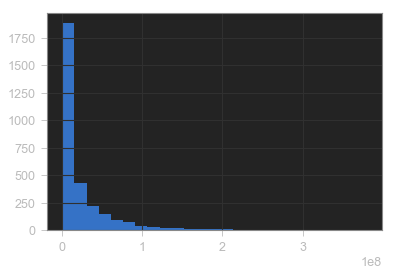

In [7]:
# Budget is also skewed.
train['budget'].hist(bins=25)

In [8]:
# $0 budget for some movies?
train['budget'].describe()

count    3.000000e+03
mean     2.253133e+07
std      3.702609e+07
min      0.000000e+00
25%      0.000000e+00
50%      8.000000e+06
75%      2.900000e+07
max      3.800000e+08
Name: budget, dtype: float64

In [9]:
print('Movies with 0$ Budget:', len(train[train['budget'] == 0]))
train[train['budget'] == 0].head()

Movies with 0$ Budget: 812


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
7,8,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,tt0391024,en,Control Room,A chronicle which provides a rare window into ...,1.949044,...,1/15/04,84.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,Different channels. Different truths.,Control Room,"[{'id': 917, 'name': 'journalism'}, {'id': 163...","[{'cast_id': 2, 'character': 'Himself', 'credi...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...",2586511
8,9,"[{'id': 256377, 'name': 'The Muppet Collection...",0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,tt0117110,en,Muppet Treasure Island,After telling the story of Flint's last journe...,6.902423,...,2/16/96,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Set sail for Muppet mayhem!,Muppet Treasure Island,"[{'id': 2041, 'name': 'island'}, {'id': 4418, ...","[{'cast_id': 1, 'character': 'Long John Silver...","[{'credit_id': '52fe43c89251416c7501deb3', 'de...",34327391
11,12,"[{'id': 48190, 'name': 'Revenge of the Nerds C...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt0093857,en,Revenge of the Nerds II: Nerds in Paradise,The members of the Lambda Lambda Lambda frater...,10.543750,...,7/10/87,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They're Back!,Revenge of the Nerds II: Nerds in Paradise,"[{'id': 5801, 'name': 'nerd'}, {'id': 6876, 'n...","[{'cast_id': 2, 'character': 'Lewis Skolnick',...","[{'credit_id': '52fe46f49251416c750891e9', 'de...",22642033
17,18,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,tt1700845,en,The Invisible Woman,"In 1857, at the height of his fame and fortune...",4.183558,...,12/25/13,111.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,His greatest story was the one he could never ...,The Invisible Woman,"[{'id': 5565, 'name': 'biography'}, {'id': 180...","[{'cast_id': 7, 'character': 'Charles Dickens'...","[{'credit_id': '53b94a260e0a2676c7009b37', 'de...",1234254


I'll come back to budget and update the values using a linear regression approach.  But it will be helpful to have as much information as possible for other features like runtime as this might affect the total budget.

In [10]:
# Create columns for year, month, and day of week
train['release_date'] = pd.to_datetime(train['release_date'], infer_datetime_format=True)
train['release_day'] = train['release_date'].apply(lambda t: t.day)
train['release_weekday'] = train['release_date'].apply(lambda t: t.weekday())
train['release_month'] = train['release_date'].apply(lambda t: t.month)
# Year was being interpreted as future dates in some cases so I had to adjust some values
train['release_year'] = train['release_date'].apply(lambda t: t.year if t.year < 2018 else t.year -100)

#train.drop('release_date', inplace=True)

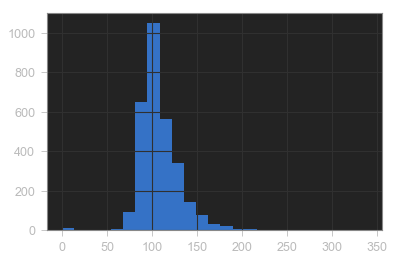

In [11]:
train['runtime'].hist(bins=25)

In [12]:
len(train[train['runtime'] == 0])

12

In [13]:
# I'll write a function that will map the average runtime for each year to movies with 0 runtie.
from collections import defaultdict
def map_runtime(df):
    df['runtime'].fillna(0)
    
    run = df[(df['runtime'].notnull()) & (df['runtime'] != 0)]
    year_mean = run.groupby(['release_year'])['runtime'].agg('mean')
    d = dict(year_mean)
    
    for i in df[df['runtime'] == 0]:
        df['runtime'] = df.loc[:, 'release_year'].map(d)
    
    return df

In [14]:
train = map_runtime(train)
train.runtime.describe()

count    3000.000000
mean      108.286306
std         5.871085
min        53.666667
25%       105.609756
50%       107.666667
75%       109.673267
max       152.800000
Name: runtime, dtype: float64

In [15]:
train['homepage'].head()

0                                  NaN
1                                  NaN
2    http://sonyclassics.com/whiplash/
3           http://kahaanithefilm.com/
4                                  NaN
Name: homepage, dtype: object

In [16]:
# For homepage, I'll change it to 0 for NaN and 1 if a page is listed.
train['homepage'].fillna(0, inplace=True)
train.loc[train['homepage'] != 0, 'homepage'] = 1

In [17]:
train['poster_path'].head()

0    /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg
1    /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg
2    /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg
3    /aTXRaPrWSinhcmCrcfJK17urp3F.jpg
4    /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg
Name: poster_path, dtype: object

In [18]:
# For poster_path, I'll change it to 0 for NaN and 1 if a path is listed.
train['poster_path'].fillna(0, inplace=True)
train.loc[train['poster_path'] != 0, 'poster_path'] = 1

In [19]:
train['genres'].describe()

count                              2993
unique                              872
top       [{'id': 18, 'name': 'Drama'}]
freq                                266
Name: genres, dtype: object

In [20]:
# For genres, I'll fill Na values with drama (most common).  Likely a better approach available.
train.genres = train.genres.fillna('18')

In [21]:
# To fill in zero budget data points, I'll try to use correlated values as predictors
X = train[train['budget'] != 0]
for i in X.select_dtypes(include='number', exclude='datetime'):
    print(i, stats.pearsonr(X.budget, X[i]))

id (0.017909195885463886, 0.40241828602089913)
budget (1.0, 0.0)
homepage (0.2417547039471847, 1.814358753007644e-30)
popularity (0.3108474146149489, 3.1687924375628966e-50)
poster_path (nan, 1.0)
runtime (-0.01742233839140922, 0.4153330881417603)
revenue (0.7398406428204244, 0.0)
release_day (0.030095150789206496, 0.15935417726880094)
release_weekday (-0.11927488136876276, 2.1934367661662928e-08)
release_month (0.017836234957327154, 0.4043382369993158)
release_year (0.25074968918533286, 1.0101895055833836e-32)


C:\Users\micha\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\micha\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


In [22]:
# release_year and popularity correlate most strongly with budget
def map_budget(df):
    d = defaultdict()
    #df['budget'] = df['budget'].fillna(0)
    X = df[df['budget'] != 0]
    
    year_mean = pd.Series(X.groupby(['release_year'])['budget'].agg('mean'))
    d = dict(year_mean)
    
    for i in df[df['budget'] == 0]:
        df['budget'] = df.loc[:, 'release_year'].map(d)
    
    # In a few cases, there are only 1 or 2 movies provided from a given year and are filled with Na values
    df.budget = df.sort_values(by='release_year').budget.fillna(method='ffill')
    
    return df

In [23]:
train = map_budget(train)
train.budget.describe()

count    3.000000e+03
mean     3.026364e+07
std      1.234361e+07
min      5.920000e+02
25%      2.130938e+07
50%      3.376819e+07
75%      3.937068e+07
max      7.041973e+07
Name: budget, dtype: float64

In [24]:
train['belongs_to_collection'].head()

0    [{'id': 313576, 'name': 'Hot Tub Time Machine ...
1    [{'id': 107674, 'name': 'The Princess Diaries ...
2                                                  NaN
3                                                  NaN
4                                                  NaN
Name: belongs_to_collection, dtype: object

In [25]:
# belongs_to_collection NaN values can be replaced with 'none'
train['belongs_to_collection'] = train['belongs_to_collection'].fillna('none')

In [26]:
train['spoken_languages'].head()

0             [{'iso_639_1': 'en', 'name': 'English'}]
1             [{'iso_639_1': 'en', 'name': 'English'}]
2             [{'iso_639_1': 'en', 'name': 'English'}]
3    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4             [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
Name: spoken_languages, dtype: object

In [27]:
train.spoken_languages.value_counts(dropna=False)

[{'iso_639_1': 'en', 'name': 'English'}]                                                                                                                                                                                                             1817
[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'es', 'name': 'Español'}]                                                                                                                                                                       86
[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]                                                                                                                                                                      77
[{'iso_639_1': 'ru', 'name': 'Pусский'}]                                                                                                                                                                                                               45


In [28]:
# For spoken_languages I'll fill Na values with [{'iso_639_1': 'en', 'name': 'English'}]
train.spoken_languages = train.spoken_languages.fillna("[{'iso_639_1': 'en', 'name': 'English'}]")

In [29]:
train['overview'].head()

0    When Lou, who has become the "father of the In...
1    Mia Thermopolis is now a college graduate and ...
2    Under the direction of a ruthless instructor, ...
3    Vidya Bagchi (Vidya Balan) arrives in Kolkata ...
4    Marine Boy is the story of a former national s...
Name: overview, dtype: object

In [30]:
# For overview, I'll fill Na values with 'none'
train.overview = train.overview.fillna('none')

In [31]:
train['Keywords'].head()

0    [{'id': 4379, 'name': 'time travel'}, {'id': 9...
1    [{'id': 2505, 'name': 'coronation'}, {'id': 42...
2    [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...
3    [{'id': 10092, 'name': 'mystery'}, {'id': 1054...
4                                                  NaN
Name: Keywords, dtype: object

In [32]:
# For Keywords, I'll fill Na values with 'none'
train.Keywords = train.Keywords.fillna('none')

In [33]:
train.production_countries.describe()

count                                                  2945
unique                                                  321
top       [{'iso_3166_1': 'US', 'name': 'United States o...
freq                                                   1752
Name: production_countries, dtype: object

In [34]:
# For production_countries, I'll fill Na with the most common value
train.production_countries = train.production_countries.fillna("[{'iso_3166_1': 'US', 'name': 'United States of America'}]")

In [35]:
train.production_companies.value_counts()

[{'name': 'Paramount Pictures', 'id': 4}]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       51
[{'name': 'Universal Pictures', 'id': 33}]                                                                                                                                                                                                                                                                                                                                                                                                           

## Feature Engineering

In [36]:
# Create a columns for title length
title_len = []
for i in train['title']:
    title_len.append(len(i.split()))
title_len = pd.Series(title_len, name='title_length')
train = pd.concat([train,title_len], axis=1)

train['title_length'].describe()

count    3000.000000
mean        2.757000
std         1.582862
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        11.000000
Name: title_length, dtype: float64

In [37]:
# For genres, I'll make a new column counting the number of listed genre types
# This will strip out all characters except for numbers, and return this as an array
genre_ids = []
for i in train['genres']:
    i = re.findall('\d+', i)
    genre_ids.append(i)
genre_ids = pd.Series(genre_ids, name='genre_ids').astype(str)

# This will count the number of genres listed for each film
num_genre_types = []
for i in genre_ids:
    num_genre_types.append(len(i.split()))
num_genre_types = pd.Series(num_genre_types, name='num_genre_types').astype(int)
train = pd.concat([train, genre_ids, num_genre_types], axis=1)

train['num_genre_types'].describe()

count    3000.000000
mean        2.506000
std         1.112824
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: num_genre_types, dtype: float64

In [38]:
# Create column for sequels
is_sequel = []
for i in train['Keywords']:
    if 'sequel' in str(i):
        is_sequel.append(1)
    else:
        is_sequel.append(0)
is_sequel = pd.Series(is_sequel, name='is_sequel')
train = pd.concat([train, is_sequel], axis=1)

train['is_sequel'].describe()

count    3000.000000
mean        0.022000
std         0.146708
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: is_sequel, dtype: float64

In [39]:
keyword_words = []
for i in train['Keywords']:
    i = re.findall('[a-zA-Z \t]+', i)
    stopwords = ['id', 'name', ' ']
    i = [word for word in i if word not in stopwords]
    keyword_words.append(i)
keyword_words = pd.Series(keyword_words, name='keyword_words').astype(str)
train = pd.concat([train, keyword_words], axis=1)

# This will count the number of Keywords listed for each film
num_keywords = []
for i in keyword_words:
    num_keywords.append(len(i.split(',')))
num_keywords = pd.Series(num_keywords, name='num_keywords').astype(int)
train = pd.concat([train, num_keywords], axis=1)

train['num_keywords'].describe()

count    3000.000000
mean        7.482667
std         6.705770
min         1.000000
25%         3.000000
50%         6.000000
75%        11.000000
max       151.000000
Name: num_keywords, dtype: float64

In [40]:
# could use the numbers from the categories, sum them up, and then convert them to a category to target incode
keyword_ids = []
for i in train['Keywords']:
    i = re.findall('[0-9]+', i)
    keyword_ids.append(i)
keyword_ids = pd.Series(keyword_ids, name='keyword_ids')
train = pd.concat([keyword_ids, train], axis=1)
train.keyword_ids.head()

0                          [4379, 9663, 11830, 179431]
1                            [2505, 4263, 6038, 13072]
2    [1416, 1523, 1640, 2176, 14512, 14819, 33896, ...
3    [10092, 10540, 11734, 14536, 14636, 208364, 22...
4                                                   []
Name: keyword_ids, dtype: object

In [41]:
train.belongs_to_collection.head()

0    [{'id': 313576, 'name': 'Hot Tub Time Machine ...
1    [{'id': 107674, 'name': 'The Princess Diaries ...
2                                                 none
3                                                 none
4                                                 none
Name: belongs_to_collection, dtype: object

In [42]:
# Extract number from belongs to collection
collection_id = []
for i in train['belongs_to_collection']:
    i = re.findall('[0-9]+', i)
    collection_id.append(i[:1])
collection_id = pd.Series(collection_id, name='collection_id').apply(lambda x: ''.join([str(i) for i in x]))

# Fill in blank values with 'No Collection'
for i in collection_id[collection_id == ''].index:
    collection_id.loc[i] = 'No Collection'

train = pd.concat([train, collection_id], axis=1)

train['collection_id'].describe()

count              3000
unique              423
top       No Collection
freq               2396
Name: collection_id, dtype: object

In [43]:
# Add column with 1 for movies in a collection and 0 if not
is_in_collection = []
for i in train['collection_id']:
    if i != 'No Collection':
        is_in_collection.append(1)
    else:
        is_in_collection.append(0)

is_in_collection = pd.Series(is_in_collection, name='is_in_collection')
train = pd.concat([train, is_in_collection], axis=1)

train['is_in_collection'].describe()

count    3000.000000
mean        0.201333
std         0.401063
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: is_in_collection, dtype: float64

In [44]:
train['production_countries'].head()

0    [{'iso_3166_1': 'US', 'name': 'United States o...
1    [{'iso_3166_1': 'US', 'name': 'United States o...
2    [{'iso_3166_1': 'US', 'name': 'United States o...
3              [{'iso_3166_1': 'IN', 'name': 'India'}]
4        [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
Name: production_countries, dtype: object

In [45]:
# Create a column for production country (1 for US, 0 for rest of world)
# It would be helpful if countries had different codes, but they all appear to be the same so it's difficult to work with
US_prod_country = []
for i in train['production_countries']:
    if 'US' in str(i):
        US_prod_country.append(1)
    else:
        US_prod_country.append(0)
US_prod_country = pd.Series(US_prod_country, name='US_prod_country')
train = pd.concat([train, US_prod_country], axis=1)

train['US_prod_country'].describe()

count    3000.00000
mean        0.77900
std         0.41499
min         0.00000
25%         1.00000
50%         1.00000
75%         1.00000
max         1.00000
Name: US_prod_country, dtype: float64

In [46]:
# Create column for number of production countries
num_production_countries = []
for i in train['production_countries']:
    i = re.findall('[a-zA-Z \t]+', str(i))
    num_production_countries.append(str(i).count('name'))
num_production_countries = pd.Series(num_production_countries, name='num_production_countries')
train = pd.concat([train, num_production_countries], axis=1)

train['num_production_countries'].describe()

count    3000.000000
mean        1.344667
std         0.731699
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         8.000000
Name: num_production_countries, dtype: float64

In [47]:
# Create a column for each production company name and a column for the number of companies
production_company_names = []
num_production_companies = []
for i in train['production_companies']:
    i = re.findall('[a-zA-Z \t]+', str(i))
    stopwords = ['id', 'name', ' ']
    production_company_names.append([word for word in i if word not in stopwords])
    num_production_companies.append(str(i).count('name'))

production_company_1 = []
production_company_2 = []
production_company_3 = []
production_company_4 = []
production_company_5 = []
production_company_6 = []
production_company_7 = []
production_company_8 = []

for i in production_company_names:
    try:
        production_company_1.append(i[:][0:1])
        production_company_2.append(i[:][1:2])
        production_company_3.append(i[:][2:3])
        production_company_4.append(i[:][3:4])
        production_company_5.append(i[:][4:5])
        production_company_6.append(i[:][5:6])
        production_company_7.append(i[:][6:7])
        production_company_8.append(i[:][7:8])
    except:
        production_company_1.append('none')
        production_company_2.append('none')
        production_company_3.append('none')
        production_company_4.append('none')
        production_company_5.append('none')
        production_company_6.append('none')
        production_company_7.append('none')
        production_company_8.append('none')

num_production_companies = pd.Series(num_production_companies, name='num_production_companies')
production_company_1 = pd.Series(production_company_1, name='production_company_1').apply(''.join)
for i in production_company_1[production_company_1 == ''].index:
    production_company_1.iloc[i] = False
production_company_2 = pd.Series(production_company_2, name='production_company_2').apply(''.join)
for i in production_company_2[production_company_2 == ''].index:
    production_company_2.iloc[i] = False
production_company_3 = pd.Series(production_company_3, name='production_company_3').apply(''.join)
for i in production_company_3[production_company_3 == ''].index:
    production_company_3.iloc[i] = False
production_company_4 = pd.Series(production_company_4, name='production_company_4').apply(''.join)
for i in production_company_4[production_company_4 == ''].index:
    production_company_4.iloc[i] = False
production_company_5 = pd.Series(production_company_5, name='production_company_5').apply(''.join)
for i in production_company_5[production_company_5 == ''].index:
    production_company_5.iloc[i] = False
production_company_6 = pd.Series(production_company_6, name='production_company_6').apply(''.join)
for i in production_company_6[production_company_6 == ''].index:
    production_company_6.iloc[i] = False
production_company_7 = pd.Series(production_company_7, name='production_company_7').apply(''.join)
for i in production_company_7[production_company_7 == ''].index:
    production_company_7.iloc[i] = False
production_company_8 = pd.Series(production_company_8, name='production_company_8').apply(''.join)
for i in production_company_8[production_company_8 == ''].index:
    production_company_8.iloc[i] = False
train = pd.concat([train, num_production_companies, production_company_1, production_company_2,
              production_company_3, production_company_4, production_company_5, production_company_6,
              production_company_7, production_company_8], axis=1)

train.production_company_8.head()

0    False
1    False
2    False
3    False
4    False
Name: production_company_8, dtype: object

In [48]:
# Create a column for number of spoken languages
num_spoken_languages = []
for i in train['spoken_languages']:
    a = str(i).split()
    num_spoken_languages.append(a.count("'name':"))
num_spoken_languages = pd.Series(num_spoken_languages, name = 'num_spoken_languages')
train = pd.concat([train, num_spoken_languages], axis=1)

train['num_spoken_languages'].describe()

count    3000.000000
mean        1.459000
std         0.880479
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: num_spoken_languages, dtype: float64

In [49]:
# Create column for release status
status_is_released = []
for i in train['status']:
    if i == 'Released':
        status_is_released.append(1)
    else:
        status_is_released.append(0)
status_is_released = pd.Series(status_is_released, name = 'status_is_released')
train = pd.concat([train, status_is_released], axis=1)
train['status_is_released'].describe()

count    3000.000000
mean        0.998667
std         0.036497
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: status_is_released, dtype: float64

In [328]:
def data_processing(df):
    # Create columns for year, month, and day of week
    df['release_date'] = df['release_date'].fillna(method='ffill')
    df['release_date'] = pd.to_datetime(df['release_date'], infer_datetime_format=True)
    df['release_day'] = df['release_date'].apply(lambda t: t.day)
    df['release_weekday'] = df['release_date'].apply(lambda t: t.weekday())
    df['release_month'] = df['release_date'].apply(lambda t: t.month)
    # Year was being interpreted as future dates in some cases so I had to adjust some values
    df['release_year'] = df['release_date'].apply(lambda t: t.year if t.year < 2018 else t.year -100)
    
    # Function that will map the average runtime for each year to movies with 0 runtie.
    def map_runtime(df):
        df['runtime'].fillna(0)
    
        run = df[(df['runtime'].notnull()) & (df['runtime'] != 0)]
        year_mean = run.groupby(['release_year'])['runtime'].agg('mean')
        d = dict(year_mean)
    
        for i in df[df['runtime'] == 0]:
            df['runtime'] = df.loc[:, 'release_year'].map(d)
        return df
    df = map_runtime(df)
    
    # For homepage, I'll change it to 0 for NaN and 1 if a page is listed.
    df['homepage'].fillna(0, inplace=True)
    df.loc[df['homepage'] != 0, 'homepage'] = 1
    
    # For poster_path, I'll change it to 0 for NaN and 1 if a path is listed.
    df['poster_path'].fillna(0, inplace=True)
    df.loc[df['poster_path'] != 0, 'poster_path'] = 1
    
    # release_year correlates strongly with budget, so I'll use that to estimate the null values
    def map_budget(df):
        d = defaultdict()
        X = df[df['budget'] != 0]
        year_mean = pd.Series(X.groupby(['release_year'])['budget'].agg('mean'))
        d = dict(year_mean)
    
        for i in df[df['budget'] == 0]:
            df['budget'] = df.loc[:, 'release_year'].map(d)
    
        # In a few cases, there are only 1 or 2 movies provided from a given year and are filled with Na values
        df.budget = df.sort_values(by='release_year').budget.fillna(method='ffill')
        return df
    df = map_budget(df)
    
    # Fill remaining Na values
    df['belongs_to_collection'] = df['belongs_to_collection'].fillna('none')
    df.spoken_languages = df.spoken_languages.fillna("[{'iso_639_1': 'en', 'name': 'English'}]")
    df.overview = df.overview.fillna('none')
    df.Keywords = df.Keywords.fillna('none')
    df.production_countries = df.production_countries.fillna(
        "[{'iso_3166_1': 'US', 'name': 'United States of America'}]")
    df.genres = df.genres.fillna('18')
    
    ############ Feature Engineering ############
    
    # Create a columns for title length
    title_len = []
    for i in df['title']:
        title_len.append(len(str(i).split()))
    title_len = pd.Series(title_len, name='title_length')
    df = pd.concat([df, title_len], axis=1)
    
    # Create columns for genres id's and for number of genres listed
    genre_id = []
    num_genre_types = []
    for i in df['genres']:
        i = re.findall('\d+', str(i))
        genre_id.append(i)
    genre_id = pd.Series(genre_id, name='genre_id') #.apply(lambda x: ''.join([str(i) for i in x]))
    
    genre_id_1 = []
    genre_id_2 = []
    genre_id_3 = []
    genre_id_4 = []
    genre_id_5 = []
    genre_id_6 = []
    genre_id_7 = []

    for i in genre_id:
        try:
            genre_id_1.append(i[:][0:1])
            genre_id_2.append(i[:][1:2])
            genre_id_3.append(i[:][2:3])
            genre_id_4.append(i[:][3:4])
            genre_id_5.append(i[:][4:5])
            genre_id_6.append(i[:][5:6])
            genre_id_7.append(i[:][6:7])
        except:
            genre_id_1.append('none')
            genre_id_2.append('none')
            genre_id_3.append('none')
            genre_id_4.append('none')
            genre_id_5.append('none')
            genre_id_6.append('none')
            genre_id_7.append('none')
            
    genre_id_1 = pd.Series(genre_id_1, name='genre_id_1').apply(''.join)
    for i in genre_id_1[genre_id_1 == ''].index:
        genre_id_1.iloc[i] = 'none'
    genre_id_2 = pd.Series(genre_id_2, name='genre_id_2').apply(''.join)
    for i in genre_id_2[genre_id_2 == ''].index:
        genre_id_2.iloc[i] = 'none'
    genre_id_3 = pd.Series(genre_id_3, name='genre_id_3').apply(''.join)
    for i in genre_id_3[genre_id_3 == ''].index:
        genre_id_3.iloc[i] = 'none'
    genre_id_4 = pd.Series(genre_id_4, name='genre_id_4').apply(''.join)
    for i in genre_id_4[genre_id_4 == ''].index:
        genre_id_4.iloc[i] = 'none'
    genre_id_5 = pd.Series(genre_id_5, name='genre_id_5').apply(''.join)
    for i in genre_id_5[genre_id_5 == ''].index:
        genre_id_5.iloc[i] = 'none'
    genre_id_6 = pd.Series(genre_id_6, name='genre_id_6').apply(''.join)
    for i in genre_id_6[genre_id_6 == ''].index:
        genre_id_6.iloc[i] = 'none'
    genre_id_7 = pd.Series(genre_id_7, name='genre_id_7').apply(''.join)
    for i in genre_id_7[genre_id_7 == ''].index:
        genre_id_7.iloc[i] = 'none'
    
    for i in genre_id.astype(str):
        num_genre_types.append(len(i.split(',')))
    num_genre_types = pd.Series(num_genre_types, name='num_genre_types').astype(int)
    df = pd.concat([df, genre_id_1, genre_id_2, genre_id_3, genre_id_4, genre_id_5, 
                    genre_id_6, genre_id_7, num_genre_types], axis=1)
    
    # Create column for sequels
    is_sequel = []
    for i in df['Keywords']:
        if 'sequel' in str(i):
            is_sequel.append(1)
        else:
            is_sequel.append(0)
    is_sequel = pd.Series(is_sequel, name='is_sequel')
    df = pd.concat([df, is_sequel], axis=1)
    
    keyword_words = []
    for i in df['Keywords']:
        i = re.findall('[a-zA-Z \t]+', str(i))
        stopwords = ['id', 'name', ' ']
        i = [word for word in i if word not in stopwords]
        keyword_words.append(i)
    keyword_words = pd.Series(keyword_words, name='keyword_words')
    df = pd.concat([df, keyword_words], axis=1)

    # This will count the number of Keywords listed for each film
    num_keywords = []
    for i in keyword_words:
        num_keywords.append(len(str(i).split(',')))
    num_keywords = pd.Series(num_keywords, name='num_keywords').astype(int)
    df = pd.concat([df, num_keywords], axis=1)
    
    # Create column for Keyword Id numbers
    keyword_ids = []
    for i in df['Keywords']:
        i = re.findall('[0-9]+', str(i))
        keyword_ids.append(i)
    keyword_ids = pd.Series(keyword_ids, name='keyword_ids')
    #df = pd.concat([keyword_ids, df], axis=1)
    
    # Extract number from belongs to collection
    collection_id = []
    for i in df['belongs_to_collection']:
        i = re.findall('[0-9]+', str(i))
        collection_id.append(i[:1])
    collection_id= pd.Series(collection_id, name='collection_id').apply(lambda x: ''.join([str(i) for i in x]))

    # Fill in blank values with 'No Collection'
    for i in collection_id[collection_id == ''].index:
        collection_id.loc[i] = 'no collection'
    collection_id = collection_id
    df = pd.concat([df, collection_id], axis=1)
    
    # Add column with 1 for movies in a collection and 0 if not
    is_in_collection = []
    for i in df['collection_id']:
        if i != 'no collection':
            is_in_collection.append(1)
        else:
            is_in_collection.append(0)
    is_in_collection = pd.Series(is_in_collection, name='is_in_collection').astype(int)
    df = pd.concat([is_in_collection, df], axis=1)
    
    # Create a column for production country (1 for US, 0 for rest of world)
    # It would be helpful if countries had different codes, but they all appear to be the same so it's difficult to work with
    US_prod_country = []
    for i in df['production_countries']:
        if 'US' in str(i):
            US_prod_country.append(1)
        else:
            US_prod_country.append(0)
    US_prod_country = pd.Series(US_prod_country, name='US_prod_country')
    df = pd.concat([df, US_prod_country], axis=1)
    
    # Create column for number of production countries
    num_prod_countries = []
    for i in df['production_countries']:
        i = re.findall('[a-zA-Z \t]+', str(i))
        num_prod_countries.append(str(i).count('name'))
    num_prod_countries = pd.Series(num_prod_countries, name='num_production_countries')
    df = pd.concat([df, num_prod_countries], axis=1)
    
    # Create a column for each production company name and a column for the number of companies
    production_company_names = []
    num_production_companies = []
    for i in df['production_companies']:
        i = re.findall('[a-zA-Z \t]+', str(i))
        stopwords = ['id', 'name', ' ']
        production_company_names.append([word for word in i if word not in stopwords])
        num_production_companies.append(str(i).count('name'))

    production_company_1 = []
    production_company_2 = []
    production_company_3 = []
    production_company_4 = []
    production_company_5 = []
    production_company_6 = []
    production_company_7 = []
    production_company_8 = []

    for i in production_company_names:
        try:
            production_company_1.append(i[:][0:1])
            production_company_2.append(i[:][1:2])
            production_company_3.append(i[:][2:3])
            production_company_4.append(i[:][3:4])
            production_company_5.append(i[:][4:5])
            production_company_6.append(i[:][5:6])
            production_company_7.append(i[:][6:7])
            production_company_8.append(i[:][7:8])
        except:
            production_company_1.append('none')
            production_company_2.append('none')
            production_company_3.append('none')
            production_company_4.append('none')
            production_company_5.append('none')
            production_company_6.append('none')
            production_company_7.append('none')
            production_company_8.append('none')

    num_production_companies = pd.Series(num_production_companies, name='num_production_companies')
    production_company_1 = pd.Series(production_company_1, name='production_company_1').apply(''.join)
    for i in production_company_1[production_company_1 == ''].index:
        production_company_1.iloc[i] = 'none'
    production_company_2 = pd.Series(production_company_2, name='production_company_2').apply(''.join)
    for i in production_company_2[production_company_2 == ''].index:
        production_company_2.iloc[i] = 'none'
    production_company_3 = pd.Series(production_company_3, name='production_company_3').apply(''.join)
    for i in production_company_3[production_company_3 == ''].index:
        production_company_3.iloc[i] = 'none'
    production_company_4 = pd.Series(production_company_4, name='production_company_4').apply(''.join)
    for i in production_company_4[production_company_4 == ''].index:
        production_company_4.iloc[i] = 'none'
    production_company_5 = pd.Series(production_company_5, name='production_company_5').apply(''.join)
    for i in production_company_5[production_company_5 == ''].index:
        production_company_5.iloc[i] = 'none'
    production_company_6 = pd.Series(production_company_6, name='production_company_6').apply(''.join)
    for i in production_company_6[production_company_6 == ''].index:
        production_company_6.iloc[i] = 'none'
    production_company_7 = pd.Series(production_company_7, name='production_company_7').apply(''.join)
    for i in production_company_7[production_company_7 == ''].index:
        production_company_7.iloc[i] = 'none'
    production_company_8 = pd.Series(production_company_8, name='production_company_8').apply(''.join)
    for i in production_company_8[production_company_8 == ''].index:
        production_company_8.iloc[i] = 'none'
    df = pd.concat([df, num_production_companies, production_company_1, production_company_2,
              production_company_3, production_company_4, production_company_5, production_company_6,
              production_company_7, production_company_8], axis=1)
    
    # Create a column for number of spoken languages
    num_spoken_languages=[]
    for i in df['spoken_languages']:
        a = str(i).split()
        num_spoken_languages.append(a.count("'name':"))
    num_spoken_languages = pd.Series(num_spoken_languages, name = 'num_spoken_languages')
    df = pd.concat([df, num_spoken_languages], axis=1)
        
    # Create column for release status
    status_is_released = []
    for i in df['status']:
        if i == 'Released':
            status_is_released.append(1)
        else:
            status_is_released.append(0)
    status_is_released = pd.Series(status_is_released, name = 'status_is_released')
    df = pd.concat([df, status_is_released], axis=1)
    
    # Drop columns that have been engineered
    df = df.drop(['belongs_to_collection', 'genres', 'Keywords', 'belongs_to_collection', 'homepage', 'imdb_id', 
                 'original_title', 'overview', 'poster_path', 'production_companies', 'production_countries',
                 'release_date', 'spoken_languages', 'status', 'tagline', 'title', 'cast', 'crew'], axis=1)
    # Drop 'keyword_words' column for now.  Can work with it later.
    df = df.drop(['keyword_words'], axis=1)
    return reduce_mem_usage(df)

In [339]:
# Reload the data fresh and apply the processing function
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = data_processing(train)
test = data_processing(test)

Mem. usage decreased to  0.48 Mb (39.9% reduction)
Mem. usage decreased to  0.68 Mb (39.9% reduction)


#### Dealing with categorical columns

In [52]:
# There are 13 object columns that will need to be converted to numeric
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 36 columns):
is_in_collection            3000 non-null int8
id                          3000 non-null int16
budget                      3000 non-null float32
original_language           3000 non-null object
popularity                  3000 non-null float16
runtime                     3000 non-null float16
revenue                     3000 non-null int32
release_day                 3000 non-null int8
release_weekday             3000 non-null int8
release_month               3000 non-null int8
release_year                3000 non-null int16
title_length                3000 non-null int8
genre_id_1                  3000 non-null object
genre_id_2                  3000 non-null object
genre_id_3                  3000 non-null object
genre_id_4                  3000 non-null object
genre_id_5                  3000 non-null object
genre_id_6                  3000 non-null object
genre_id_7           

I'll label encode the category columns using sklearn.

In [53]:
def train_target_encoded_year(df, cols):
    """Function will take a dataframe and replace any passed categorical columns with the average revenue for each unique value from a given year."""
    for i in cols:
        d = df.groupby(['release_year', i]).agg({'revenue':'mean'})
        df = df.set_index(['release_year', i], drop=False)
        df[i] = d.revenue
        df = df.reset_index(drop=True)
    return df

In [216]:
def test_target_encoded_year(df_train, df_test, cols):
    """Function will take a dataframe and replace any passed categorical columns with the unique average revenue per year generated from the training dataframe."""
    for i in cols:
        d = df_train.groupby(['release_year', i]).agg({'revenue':'mean'})
        df_test = df_test.set_index(['release_year', i], drop=False)
        df_test[i] = d.revenue
        df_test = df_test.reset_index(drop=True)
    return df_test

In [55]:
def target_encode(df, target_feature, m = 300): 
    d = defaultdict()
    target_mean = df[target_feature].mean()
    
    # Map values and create dictionary   
    for cat_feature in df.select_dtypes(include='category'):
        group_target_mean = df.groupby([cat_feature])[target_feature].agg('mean')
        group_target_count = df.groupby([cat_feature])[target_feature].agg('count')
        smooth = (group_target_count * group_target_mean + m * target_mean) / (group_target_count + m)
        k = pd.Series(df[cat_feature])
        v = df[cat_feature].map(smooth)
        d[cat_feature] = dict(zip(k, v))
        df[cat_feature] = df[cat_feature].map(smooth)
        
    return df, d

for i in df_test[df_test.isnull()]: #df_test[df_test.isnull()].index
    if i['release_year'] in d: # df_test.iloc[i]['release_year'] in d:
        X[i] = X[i].map(d[i]) # df_test[]

In [248]:
def test_target_encoded_year(df_train, df_test):
    """Function will take a dataframe and replace any passed categorical columns with the unique average revenue per year generated from the training dataframe."""
    cols = df_test.select_dtypes(include='object').columns
    for col in cols:
        d = df_train.groupby(['release_year', col]).agg({'revenue':'mean'})
        df_test = df_test.set_index(['release_year', col], drop=False)
        df_test[col] = d.revenue
        df_test = df_test.reset_index(drop=True)
        
    # There are a numerous missing values in the test set after processing so I'll fill them with the yearly avg.
    for col in cols:
        #d = defaultdict()
        X = df_test[df_test[col].notnull()]
        year_mean = pd.Series(X.groupby(['release_year'])[col].agg('mean'))
        d = dict(year_mean)
    
        for i in df_test[df_test['budget'].isnull()]:
            df_test[col] = df_test.loc[:, 'release_year'].map(d)
    
    return reduce_mem_usage(df_test)

In [ ]:
# The numeric columns look okay, but budget may need normalization as the st. dev is quite large
train.describe()

In [ ]:
# Budget normalization - Didn't improve model accuracy for linear regression (remained the same)
#train.budget = (train.budget - train.budget.mean()) / (train.budget.max() - train.budget.min())
#train.head()

In [301]:
from category_encoders import *
from sklearn.preprocessing import LabelEncoder

In [330]:
# Make complete list of genre ids
genre_ids = train['genre_id_1']
for i in train.loc[:, 'genre_id_2': 'genre_id_7'].columns:
    genre_ids = pd.concat([genre_ids, train[i]], axis=0)

le = LabelEncoder()
lab_enc = le.fit_transform(genre_ids)
genre_ids_dict = dict(zip(genre_ids, lab_enc))

# Map genre_ids_dict to genre_id columns
for i in train.loc[:, 'genre_id_1': 'genre_id_7'].columns:
    train[i] = train[i].map(genre_ids_dict)

In [331]:
train.loc[:, 'production_company_2': 'production_company_8'].head()

,production_company_2,production_company_3,production_company_4,production_company_5,production_company_6,production_company_7,production_company_8
0,United Artists,Metro,Goldwyn,Mayer,MGM,none,none
1,none,none,none,none,none,none,none
2,Blumhouse Productions,Right of Way Films,none,none,none,none,none
3,none,none,none,none,none,none,none
4,none,none,none,none,none,none,none


In [332]:
# Make complete list of production companies
prod_companies = train['production_company_1']
for i in train.loc[:, 'production_company_2': 'production_company_8'].columns:
    prod_companies = pd.concat([prod_companies, train[i]], axis=0)

le = LabelEncoder()
lab_enc = le.fit_transform(prod_companies)
prod_companies_dict = dict(zip(prod_companies, lab_enc))

# Map genre_ids_dict to genre_id columns
for i in train.loc[:, 'production_company_1': 'production_company_8'].columns:
    train[i] = train[i].map(prod_companies_dict)

In [335]:
le = LabelEncoder()
train['collection_id'] = le.fit_transform(train['collection_id'])
train['original_language'] = le.fit_transform(train['original_language'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 36 columns):
is_in_collection            3000 non-null int8
id                          3000 non-null int16
budget                      3000 non-null float32
original_language           3000 non-null int32
popularity                  3000 non-null float16
runtime                     3000 non-null float16
revenue                     3000 non-null int32
release_day                 3000 non-null int8
release_weekday             3000 non-null int8
release_month               3000 non-null int8
release_year                3000 non-null int16
title_length                3000 non-null int8
genre_id_1                  3000 non-null int64
genre_id_2                  3000 non-null int64
genre_id_3                  3000 non-null int64
genre_id_4                  3000 non-null int64
genre_id_5                  3000 non-null int64
genre_id_6                  3000 non-null int64
genre_id_7                  

In [340]:
from sklearn.preprocessing import LabelEncoder
def cat_encode(df):
    le = LabelEncoder()
    
    # Make complete list of genre ids
    genre_ids = df['genre_id_1']
    for i in df.loc[:, 'genre_id_2': 'genre_id_7'].columns:
        genre_ids = pd.concat([genre_ids, df[i]], axis=0)

    lab_enc_genres = le.fit_transform(genre_ids)
    genre_ids_dict = dict(zip(genre_ids, lab_enc_genres))

    # Map genre_ids_dict to genre_id columns
    for i in df.loc[:, 'genre_id_1': 'genre_id_7'].columns:
        df[i] = df[i].map(genre_ids_dict)

    # Make complete list of production companies
    prod_companies = df['production_company_1']
    for i in df.loc[:, 'production_company_2': 'production_company_8'].columns:
        prod_companies = pd.concat([prod_companies, df[i]], axis=0)

    lab_enc_comp = le.fit_transform(prod_companies)
    prod_companies_dict = dict(zip(prod_companies, lab_enc_comp))

    # Map genre_ids_dict to genre_id columns
    for i in df.loc[:, 'production_company_1': 'production_company_8'].columns:
        df[i] = df[i].map(prod_companies_dict)
        
    df['collection_id'] = le.fit_transform(df['collection_id'])
    df['original_language'] = le.fit_transform(df['original_language'])
    
    return reduce_mem_usage(df)

In [343]:
train = cat_encode(train)
test = cat_encode(test)
train.info()

Mem. usage decreased to  0.16 Mb (64.5% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 36 columns):
is_in_collection            3000 non-null int8
id                          3000 non-null int16
budget                      3000 non-null float32
original_language           3000 non-null int8
popularity                  3000 non-null float16
runtime                     3000 non-null float16
revenue                     3000 non-null int32
release_day                 3000 non-null int8
release_weekday             3000 non-null int8
release_month               3000 non-null int8
release_year                3000 non-null int16
title_length                3000 non-null int8
genre_id_1                  3000 non-null int8
genre_id_2                  3000 non-null int8
genre_id_3                  3000 non-null int8
genre_id_4                  3000 non-null int8
genre_id_5                  3000 non-null int8
genre_id_6                  300

In [345]:
# Get an idea of what correlates most strongly with revenue
for i in train.columns:
    print(i, stats.pearsonr(train[i], train['revenue']))

is_in_collection (0.3394249988710912, 8.822682201754573e-82)
id (0.0006095635294543107, 0.9733769342889089)
budget (0.1584856653167129, 2.496733264319085e-18)
original_language (-0.09229646266123444, 4.105701642952348e-07)
popularity (0.0, 1.0)
runtime (0.0, 1.0)
revenue (1.0, 0.0)
release_day (0.04569913504538599, 0.012303793328008152)
release_weekday (-0.14109009535798767, 8.263944065848156e-15)
release_month (0.0201639562122308, 0.26955958869104796)
release_year (0.1379329200546047, 3.247716177921109e-14)
title_length (0.09629030482419586, 1.2630957399106784e-07)
genre_id_1 (-0.0993356540354809, 4.9789836363819086e-08)
genre_id_2 (-0.08200122533251733, 6.8888132880519705e-06)
genre_id_3 (-0.15117567984925706, 8.456561314003533e-17)
genre_id_4 (-0.11019995168467128, 1.4321498347342908e-09)
genre_id_5 (-0.030921351163622594, 0.09039243795759676)
genre_id_6 (-0.023659914028199055, 0.1951312054107617)
genre_id_7 (0.006003837916781562, 0.7423751493481074)
num_genre_types (0.1632704679907

#### Model Building and Parameter Tuning

In [346]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [347]:
X = train.drop(['id', 'revenue'], axis=1)
y = train['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

I think it's useful to first use a basic linear regression model.  We can make a more complex model later.

In [348]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

C:\Users\micha\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


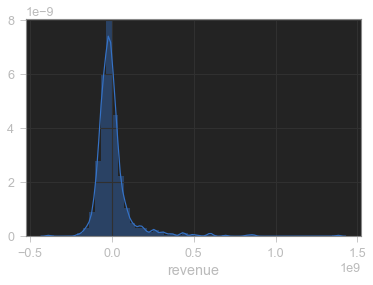

In [349]:
sns.distplot((y_test-pred),bins=50)

In [350]:
def rmsle(y_true, y_pred):
    return 'rmsle', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

In [351]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print('RMSLE:', rmsle(y_test, pred))

MAE: 65279556.328888886
MSE: 1.4582338462940332e+16
RMSE: 120757353.65989241
RMSLE: ('rmsle', 3.0337372785111856, False)


C:\Users\micha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


In [352]:
from lightgbm import LGBMRegressor
lr = LGBMRegressor(boosting_type='dart', random_state=101)

In [353]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold

In [354]:
# grid_1
params_1 = {'num_leaves': [20, 40, 60, 80, 100], #20 is best
          'max_depth': [-1, 2, 4, 6, 8], # -1 is best
          'min_data_in_leaf': [20, 50, 100, 200], #20 is best
          #'learning_rate': [0.05, 0.1, 0.15, 0.2],
          #'n_estimators': [100, 500, 1000],
          'subsample_for_bin': [200000],
          #'objective': 'regression',
          #'class_weight': None,
          'min_split_gain': [0.0],
          'min_child_weight': [0.001],
          #'subsample': [0.5, 0.75, 1.0],
          'subsample_freq': [0],
          #'colsample_bytree': [0.5, 0.75, 1.0],
          #'reg_alpha': [0.0, 0.25, 0.5, 0.75, 1],
          #'reg_lambda': [0.0, 0.25, 0.5, 0.75, 1],
          'random_state': [101],
          'n_jobs': [-1]
         }

In [355]:
grid_1 = GridSearchCV(lr, param_grid=params_1, scoring='neg_mean_squared_error', cv=5)
grid_1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=101,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'num_leaves': [20, 40, 60, 80, 100], 'max_depth': [-1, 2, 4, 6, 8], 'min_data_in_leaf': [20, 50, 100, 200], 'subsample_for_bin': [200000], 'min_split_gain': [0.0], 'min_child_weight': [0.001], 'subsample_freq': [0], 'random_state': [101], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [356]:
print(grid_1.best_params_)
print(grid_1.best_score_)
print(grid_1.best_estimator_)

{'max_depth': -1, 'min_child_weight': 0.001, 'min_data_in_leaf': 20, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 20, 'random_state': 101, 'subsample_for_bin': 200000, 'subsample_freq': 0}
-8972681120753005.0
LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=20, objective=None,
       random_state=101, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [357]:
# grid_2
params_2 = {'num_leaves': [10, 15, 20], # 20 is best
          'max_depth': [-1],
          'min_data_in_leaf': [10, 15, 20], # 20 is best
          #'learning_rate': [0.05, 0.1, 0.15, 0.2],
          #'n_estimators': [100, 500, 1000],
          'subsample_for_bin': [200000],
          #'objective': 'regression',
          #'class_weight': None,
          'min_split_gain': [0.0],
          'min_child_weight': [0.001],
          #'subsample': [0.5, 0.75, 1.0],
          'subsample_freq': [0],
          #'colsample_bytree': [0.5, 0.75, 1.0],
          #'reg_alpha': [0.0, 0.25, 0.5, 0.75, 1],
          #'reg_lambda': [0.0, 0.25, 0.5, 0.75, 1],
          'random_state': [101],
          'n_jobs': [-1]
         }

In [358]:
grid_2 = GridSearchCV(lr, param_grid=params_2, scoring='neg_mean_squared_error', cv=5)
grid_2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=101,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'num_leaves': [10, 15, 20], 'max_depth': [-1], 'min_data_in_leaf': [10, 15, 20], 'subsample_for_bin': [200000], 'min_split_gain': [0.0], 'min_child_weight': [0.001], 'subsample_freq': [0], 'random_state': [101], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [359]:
print(grid_2.best_params_)
print(grid_2.best_score_)
print(grid_2.best_estimator_)

{'max_depth': -1, 'min_child_weight': 0.001, 'min_data_in_leaf': 20, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 20, 'random_state': 101, 'subsample_for_bin': 200000, 'subsample_freq': 0}
-8972681120753005.0
LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=20, objective=None,
       random_state=101, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [363]:
# grid_3
params_3 = {'num_leaves': [20],
          'max_depth': [-1],
          'min_data_in_leaf': [20],
          'learning_rate': [0.05, 0.1, 0.15, 0.2], # 0.2 is best
          'n_estimators': [100, 250, 500, 1000], # 500 is best
          'subsample_for_bin': [200000],
          #'objective': 'regression',
          #'class_weight': None,
          'min_split_gain': [0.0],
          'min_child_weight': [0.001],
          #'subsample': [0.5, 0.75, 1.0],
          'subsample_freq': [0],
          #'colsample_bytree': [0.5, 0.75, 1.0],
          #'reg_alpha': [0.0, 0.25, 0.5, 0.75, 1],
          #'reg_lambda': [0.0, 0.25, 0.5, 0.75, 1],
          'random_state': [101],
          'n_jobs': [-1]
         }

In [364]:
grid_3 = GridSearchCV(lr, param_grid=params_3, scoring='neg_mean_squared_error', cv=5)
grid_3.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=101,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'num_leaves': [20], 'max_depth': [-1], 'min_data_in_leaf': [20], 'learning_rate': [0.05, 0.1, 0.15, 0.2], 'n_estimators': [100, 250, 500, 1000], 'subsample_for_bin': [200000], 'min_split_gain': [0.0], 'min_child_weight': [0.001], 'subsample_freq': [0], 'random_state': [101], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [365]:
print(grid_3.best_params_)
print(grid_3.best_score_)
print(grid_3.best_estimator_)

{'learning_rate': 0.2, 'max_depth': -1, 'min_child_weight': 0.001, 'min_data_in_leaf': 20, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 20, 'random_state': 101, 'subsample_for_bin': 200000, 'subsample_freq': 0}
-8039957543572287.0
LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.2, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
       n_estimators=500, n_jobs=-1, num_leaves=20, objective=None,
       random_state=101, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [366]:
# grid_4
params_4 = {'num_leaves': [20],
          'max_depth': [-1],
          'min_data_in_leaf': [20],
          'learning_rate': [0.2], 
          'n_estimators': [500],
          'subsample_for_bin': [200000],
          #'objective': 'regression',
          #'class_weight': None,
          'min_split_gain': [0.0],
          'min_child_weight': [0.001],
          'subsample': [0.1, 0.25, 0.5, 0.75, 1.0], # 0.1 is best
          'subsample_freq': [0],
          'colsample_bytree': [0.1, 0.25, 0.5, 0.75, 1.0], # 0.75 is best
          #'reg_alpha': [0.0, 0.25, 0.5, 0.75, 1],
          #'reg_lambda': [0.0, 0.25, 0.5, 0.75, 1],
          'random_state': [101],
          'n_jobs': [-1]
         }

In [367]:
grid_4 = GridSearchCV(lr, param_grid=params_4, scoring='neg_mean_squared_error', cv=5)
grid_4.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=101,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'num_leaves': [20], 'max_depth': [-1], 'min_data_in_leaf': [20], 'learning_rate': [0.2], 'n_estimators': [500], 'subsample_for_bin': [200000], 'min_split_gain': [0.0], 'min_child_weight': [0.001], 'subsample': [0.1, 0.25, 0.5, 0.75, 1.0], 'subsample_freq': [0], 'colsample_bytree': [0.1, 0.25, 0.5, 0.75, 1.0], 'random_state': [101], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose

In [368]:
print(grid_4.best_params_)
print(grid_4.best_score_)
print(grid_4.best_estimator_)

{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'max_depth': -1, 'min_child_weight': 0.001, 'min_data_in_leaf': 20, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 20, 'random_state': 101, 'subsample': 0.1, 'subsample_for_bin': 200000, 'subsample_freq': 0}
-7962069953924532.0
LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=0.75,
       learning_rate=0.2, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
       n_estimators=500, n_jobs=-1, num_leaves=20, objective=None,
       random_state=101, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.1, subsample_for_bin=200000, subsample_freq=0)


In [369]:
# grid_5
params_5 = {'num_leaves': [20],
          'max_depth': [-1],
          'min_data_in_leaf': [20],
          'learning_rate': [0.2], 
          'n_estimators': [500],
          'subsample_for_bin': [200000],
          #'objective': 'regression',
          #'class_weight': None,
          'min_split_gain': [0.0],
          'min_child_weight': [0.001],
          'subsample': [0.1],
          'subsample_freq': [0],
          'colsample_bytree': [0.75],
          'reg_alpha': [0.0, 0.25, 0.5, 0.75, 1], # 0 is best
          'reg_lambda': [0.0, 0.25, 0.5, 0.75, 1], # 0 is best
          'random_state': [101],
          'n_jobs': [-1]
         }

In [370]:
grid_5 = GridSearchCV(lr, param_grid=params_4, scoring='neg_mean_squared_error', cv=5)
grid_5.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=101,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'num_leaves': [20], 'max_depth': [-1], 'min_data_in_leaf': [20], 'learning_rate': [0.2], 'n_estimators': [500], 'subsample_for_bin': [200000], 'min_split_gain': [0.0], 'min_child_weight': [0.001], 'subsample': [0.1, 0.25, 0.5, 0.75, 1.0], 'subsample_freq': [0], 'colsample_bytree': [0.1, 0.25, 0.5, 0.75, 1.0], 'random_state': [101], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose

In [371]:
print(grid_5.best_params_)
print(grid_5.best_score_)
print(grid_5.best_estimator_)

{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'max_depth': -1, 'min_child_weight': 0.001, 'min_data_in_leaf': 20, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 20, 'random_state': 101, 'subsample': 0.1, 'subsample_for_bin': 200000, 'subsample_freq': 0}
-7962069953924532.0
LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=0.75,
       learning_rate=0.2, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
       n_estimators=500, n_jobs=-1, num_leaves=20, objective=None,
       random_state=101, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.1, subsample_for_bin=200000, subsample_freq=0)


In [372]:
lr = LGBMRegressor(boosting_type='dart',
                   num_leaves=20,
                   max_depth=-1,
                   min_data_in_leaf=20, 
                   learning_rate=0.2,
                   n_estimators=500,
                   subsample_for_bin=200000,
                   #objective='regression',
                   class_weight=None,
                   min_split_gain=0.0,
                   min_child_weight=0.001,
                   subsample=0.1,
                   subsample_freq=0,
                   colsample_bytree=0.75,
                   reg_alpha=0.0,
                   reg_lambda=0.0,
                   random_state=101,
                   n_jobs=-1)

In [373]:
lr.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=rmsle,
        early_stopping_rounds=500)

[1]	valid_0's l2: 1.69918e+16	valid_0's rmsle: 3.62417
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's l2: 1.45016e+16	valid_0's rmsle: 3.54595
[3]	valid_0's l2: 1.33889e+16	valid_0's rmsle: 3.49049
[4]	valid_0's l2: 1.23438e+16	valid_0's rmsle: 3.42875
[5]	valid_0's l2: 1.14374e+16	valid_0's rmsle: 3.37382
[6]	valid_0's l2: 1.09088e+16	valid_0's rmsle: 3.3188
[7]	valid_0's l2: 1.05372e+16	valid_0's rmsle: 3.27418
[8]	valid_0's l2: 1.03835e+16	valid_0's rmsle: 3.23247
[9]	valid_0's l2: 1.02827e+16	valid_0's rmsle: 3.19183
[10]	valid_0's l2: 1.04423e+16	valid_0's rmsle: 3.23522
[11]	valid_0's l2: 1.03566e+16	valid_0's rmsle: 3.19589
[12]	valid_0's l2: 1.03561e+16	valid_0's rmsle: 3.16648
[13]	valid_0's l2: 1.02922e+16	valid_0's rmsle: 3.12533
[14]	valid_0's l2: 1.02034e+16	valid_0's rmsle: 3.07477
[15]	valid_0's l2: 1.02398e+16	valid_0's rmsle: 3.1098
[16]	valid_0's l2: 1.02544e+16	valid_0's rmsle: 3.06409
[17]	valid_0's l2: 1.031e+16	valid_0's rmsle: 3.0947

C:\Users\micha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


[60]	valid_0's l2: 1.03155e+16	valid_0's rmsle: 2.67567
[61]	valid_0's l2: 1.03525e+16	valid_0's rmsle: 2.74649
[62]	valid_0's l2: 1.03827e+16	valid_0's rmsle: 2.78761
[63]	valid_0's l2: 1.027e+16	valid_0's rmsle: 2.79785
[64]	valid_0's l2: 1.02489e+16	valid_0's rmsle: 2.83777
[65]	valid_0's l2: 1.02706e+16	valid_0's rmsle: 2.85841
[66]	valid_0's l2: 1.02511e+16	valid_0's rmsle: 2.84711
[67]	valid_0's l2: 1.02621e+16	valid_0's rmsle: 2.84214
[68]	valid_0's l2: 1.02758e+16	valid_0's rmsle: 2.87117
[69]	valid_0's l2: 1.0365e+16	valid_0's rmsle: 2.89303
[70]	valid_0's l2: 1.03458e+16	valid_0's rmsle: 2.9254
[71]	valid_0's l2: 1.03176e+16	valid_0's rmsle: 2.92144
[72]	valid_0's l2: 1.02951e+16	valid_0's rmsle: 2.91034
[73]	valid_0's l2: 1.03129e+16	valid_0's rmsle: 2.92619
[74]	valid_0's l2: 1.0309e+16	valid_0's rmsle: 2.94407
[75]	valid_0's l2: 1.03098e+16	valid_0's rmsle: 2.9521
[76]	valid_0's l2: 1.03012e+16	valid_0's rmsle: 2.95009
[77]	valid_0's l2: 1.03008e+16	valid_0's rmsle: 2.9477

[207]	valid_0's l2: 1.02707e+16	valid_0's rmsle: 2.87272
[208]	valid_0's l2: 1.02749e+16	valid_0's rmsle: 2.86827
[209]	valid_0's l2: 1.02647e+16	valid_0's rmsle: 2.87151
[210]	valid_0's l2: 1.02537e+16	valid_0's rmsle: 2.87389
[211]	valid_0's l2: 1.026e+16	valid_0's rmsle: 2.88678
[212]	valid_0's l2: 1.025e+16	valid_0's rmsle: 2.88607
[213]	valid_0's l2: 1.02436e+16	valid_0's rmsle: 2.88826
[214]	valid_0's l2: 1.02305e+16	valid_0's rmsle: 2.89171
[215]	valid_0's l2: 1.0231e+16	valid_0's rmsle: 2.89501
[216]	valid_0's l2: 1.02328e+16	valid_0's rmsle: 2.90866
[217]	valid_0's l2: 1.02478e+16	valid_0's rmsle: 2.8935
[218]	valid_0's l2: 1.02674e+16	valid_0's rmsle: 2.89834
[219]	valid_0's l2: 1.02597e+16	valid_0's rmsle: 2.9126
[220]	valid_0's l2: 1.02552e+16	valid_0's rmsle: 2.90396
[221]	valid_0's l2: 1.02546e+16	valid_0's rmsle: 2.90375
[222]	valid_0's l2: 1.02796e+16	valid_0's rmsle: 2.89914
[223]	valid_0's l2: 1.02668e+16	valid_0's rmsle: 2.89911
[224]	valid_0's l2: 1.02659e+16	valid_

[359]	valid_0's l2: 1.0364e+16	valid_0's rmsle: 2.83702
[360]	valid_0's l2: 1.03754e+16	valid_0's rmsle: 2.83658
[361]	valid_0's l2: 1.03716e+16	valid_0's rmsle: 2.84137
[362]	valid_0's l2: 1.03676e+16	valid_0's rmsle: 2.83829
[363]	valid_0's l2: 1.03875e+16	valid_0's rmsle: 2.83959
[364]	valid_0's l2: 1.04295e+16	valid_0's rmsle: 2.8439
[365]	valid_0's l2: 1.04273e+16	valid_0's rmsle: 2.86568
[366]	valid_0's l2: 1.04217e+16	valid_0's rmsle: 2.85563
[367]	valid_0's l2: 1.04163e+16	valid_0's rmsle: 2.83445
[368]	valid_0's l2: 1.03931e+16	valid_0's rmsle: 2.85033
[369]	valid_0's l2: 1.03939e+16	valid_0's rmsle: 2.84
[370]	valid_0's l2: 1.03866e+16	valid_0's rmsle: 2.84769
[371]	valid_0's l2: 1.03836e+16	valid_0's rmsle: 2.84831
[372]	valid_0's l2: 1.03789e+16	valid_0's rmsle: 2.83701
[373]	valid_0's l2: 1.03253e+16	valid_0's rmsle: 2.84701
[374]	valid_0's l2: 1.03216e+16	valid_0's rmsle: 2.85366
[375]	valid_0's l2: 1.03202e+16	valid_0's rmsle: 2.86143
[376]	valid_0's l2: 1.0315e+16	valid

LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=0.75,
       learning_rate=0.2, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
       n_estimators=500, n_jobs=-1, num_leaves=20, objective=None,
       random_state=101, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.1, subsample_for_bin=200000, subsample_freq=0)

In [374]:
pred = lr.predict(X_test, num_iteration=lr.best_iteration_)

In [375]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print('RMSLE:', rmsle(y_test, pred))

MAE: 58305343.05678833
MSE: 1.843965416713692e+16
RMSE: 135792688.19467756
RMSLE: ('rmsle', 2.708189759118778, False)


C:\Users\micha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


In [378]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['revenue'] = lr.predict(test.drop('id', axis=1), num_iteration=lr.best_iteration_)

In [381]:
submission.to_csv('TMDB_test_predictions.csv', index=False)